## Import libraries and mount the drive

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math
import tensorflow_probability as tfp
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.2.0-rc3
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('./drive/My Drive/Master_thesis/generation')
from dataset_helpers import load_dataset

## Loading train, validation and test sets

In [0]:
def load_datasets():
    validation = load_dataset(prefix_path + 'brats2015_validation_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=False)
    training = load_dataset(prefix_path + 'brats2015_training_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    testing = load_dataset(prefix_path + 'brats2015_testing_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    return training, validation , testing

In [0]:
prefix_path = './drive/My Drive/Master_thesis/datasets/'
BATCH_SIZE = 32

training, validation, testing = load_datasets()

## Load some useful functions




In [0]:
def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
    if len(args) == 5:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        return image0, image1, image2, image3, image4
    if len(args) == 7:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        image6 = tf.image.resize_with_crop_or_pad(args[6], 155, 194)
        return image0, image1, image2, image3, image4, image5, image6
    if len(args) == 8:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        image6 = tf.image.resize_with_crop_or_pad(args[6], 155, 194)
        image7 = tf.image.resize_with_crop_or_pad(args[7], 155, 194)
        return image0, image1, image2, image3, image4, image5, image6, image7
    return image0, image1, image2, image3

In [0]:
# MASK THE SEGMENTATION with the prediciton and the ground_truth and then compute the metrics (even if there is the black pixels
# it should give me an idea about how much is going the generation of the tumor during the generation. of course the score
# will be influeced (biased) by all the black pixels.)

def retrieve_tumor_area(*args):  # ground_truth, prediction1, prediction2, segmentation, prediction3*
    ground_truth_np = args[0].numpy()
    prediction1_np = args[1].numpy()
    prediction2_np = args[2].numpy()
    segmentation_np = args[3].numpy()
    if len(args) == 5:
        prediction3_np = args[4].numpy()
    
    # I want to remove all the pixels not relevant wrt the tumor area. 
    idx = (segmentation_np==0)      
    ground_truth_np[idx] = segmentation_np[idx]
    prediction1_np[idx] = segmentation_np[idx]
    prediction2_np[idx] = segmentation_np[idx]
    if len(args) == 5:
        prediction3_np[idx] = segmentation_np[idx]
        return ground_truth_np, prediction1_np, prediction2_np, prediction3_np

    return ground_truth_np, prediction1_np, prediction2_np      # Now the images are ready to be evaluated

In [0]:
# this method was tested to work with 5, 7 and 32 images.

def plot_images_new(*args, gen_t1): 
    
    if len(args) == 2:
        display_list = [args[0], args[1]]   # input, gt, prediction, gt masked, pred masked
        title = [r'${T_{1c}}$', r'$\mathit{T_{1c\ tumor\ area}}$']
        figsize = (7, 4)
    elif len(args) == 4:
        display_list = [args[0], args[1], args[2], args[3]]   # input, gt, prediction, gt masked, pred masked
        title = [r'$\mathit{T_{1}}$', r'$\mathit{T_{2}}$', r'$\mathit{T_{1c}}$', r'$\mathit{T_{2flair}}$']
        figsize = (12, 6)
    elif len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]   # input, gt, prediction, gt masked, pred masked
        title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 - Predicted Image']
        figsize = (14, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = [r'$\it{Input}$', r'$\it{Prediction}$', r'$\it{Ground\ Truth}$']
        figsize = (10, 5)

    elif len(args) == 6:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5]]
        if gen_t1:
            title = ['T2', 'T1c', 'Tflair', 'T1 - ground Truth', 'T1 pix2pix prediction', 'T1 MI-GAN prediction']
        else:
            title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 pix2pix prediction', 'T2 MI-GAN prediction']
        figsize = (20, 6)

    elif len(args) == 7:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6]]
        if gen_t1:
            title = ['T2', 'T1c', 'Tflair', 'T1 - ground Truth', 'T1 pix2pix prediction', 'T1 MI-GAN prediction', 'T1 MI-pix2pix prediction']
        else:
            title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 pix2pix prediction', 'T2 MI-GAN prediction', 'T2 MI-pix2pix prediction']
        figsize = (21, 8)

    elif len(args) == 9:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8]]
        if gen_t1:
            title = ['T2', 'T1c', 'Tflair', 'T1 - ground Truth', 'T1 pix2pix prediction', 'T1 MI-GAN prediction', 'GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor']
        else:
            title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 pix2pix prediction', 'T2 MI-GAN prediction', 'GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor']

        figsize = (23, 12)

    elif len(args) == 11:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10]]
        if gen_t1:
            title = ['T2', 'T1c', 'Tflair', 'T1 - ground Truth', 'T1 pix2pix prediction', 'T1 MI-GAN prediction', 'T1 MI-pix2pix prediction','GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor', 'MI-pix2pix pred tumor']
        else:
            title = ['T1', 'T1c', 'Tflair', 'T2 - ground Truth', 'T2 pix2pix prediction', 'T2 MI-GAN prediction', 'T2 MI-pix2pix prediction','GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor', 'MI-pix2pix pred tumor']

        figsize = (30, 15)
    
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.subplot(1, len(args), n).title.set_size(16)
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.subplots_adjust(left=0, bottom=None, right=0.75, top=None, wspace=0.0, hspace=None)
    plt.show()


In [0]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

In [0]:
@tf.function
def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

In [0]:
def black_images_to_nan(image): 
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])

        # if the max = min most likely it's a black image (or an image without any important information)
        if tf.math.equal(max_value, min_value):        
            print("I found a black image! at index {}".format(i))
            x = mean_normalize(image[i], min_value, max_value)
            image_normalized = image_normalized.write(i, x)
        else:
            image_normalized = image_normalized.write(i, image[i])
    image_normalized = image_normalized.stack()
    return image_normalized

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    
    return mean, std, psnr

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    return mean, std, ssim

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image

In [14]:
!pip install -q  --no-deps tensorflow-addons==0.6.0
import tensorflow_addons as tfa
print(tfa.__version__)

from tensorflow.python.ops import math_ops

def compute_mse_tumor(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    squared_difference = tf.math.squared_difference(im1,im2)
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        non_zero_elements = tf.math.count_nonzero(squared_difference[i], dtype=tf.dtypes.float32)
        sum_over_squared_difference = tf.math.reduce_sum(squared_difference[i])
        x = tf.math.divide(sum_over_squared_difference, non_zero_elements) 

        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image


def compute_psnr_tumor(image1, image2):       # mean squared error
    max_val=1.0
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    squared_difference = tf.math.squared_difference(im1,im2)
    psnr_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        non_zero_elements = tf.math.count_nonzero(squared_difference[i], dtype=tf.dtypes.float32)
        sum_over_squared_difference = tf.math.reduce_sum(squared_difference[i])
        x = tf.math.divide(sum_over_squared_difference, non_zero_elements) 
        
        psnr_val = math_ops.subtract(20 * math_ops.log(max_val) / math_ops.log(10.0), np.float32(10 / np.log(10)) * math_ops.log(x), name='psnr')
        psnr_per_image = psnr_per_image.write(i, psnr_val)

    psnr_per_image = psnr_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((psnr_per_image), tf.math.is_finite(psnr_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr_per_image), tf.math.is_finite(psnr_per_image)))
    return mean, std, psnr_per_image

     |████████████████████████████████| 1.8MB 2.8MB/s 
0.6.0


# Load the models

In [0]:
pix2pix_tflair = tf.keras.models.load_model('drive/My Drive/Master_thesis/generation/models_h5/pix2pix/gen_TFlair_27ep.h5', compile=False)

In [0]:
# proposed model
MIGAN_flair = tf.keras.models.load_model('drive/My Drive/Master_thesis/generation/models_h5/MI-GAN/gen_tFlair_25ep_v4.3.h5', compile=False)

MIpix2pix_flair = tf.keras.models.load_model('drive/My Drive/Master_thesis/generation/models_h5/MI-pix2pix/gen_tFlair_35ep_v2.h5', compile=False)

# Generate the prediction

In [0]:
"""idx = 0
for raw_record in testing.take(3):
    t1, t2, t1c, tflair, ground_truth = take_images_from_raw(raw_record, ot=True)

    multi_input = tf.concat([t1, t2, tflair], 3)

    prediction1 = pix2pix_t1c(t1, training=False)
    prediction2 = MI_GAN_t1c(multi_input, training=False)
    prediction3 = MI_pix2pix_t1c(multi_input, training=False)
    if idx == 2:
        plot_images_new(t1c, prediction1, gen_t1=True)

    idx += 1

print(prediction.shape)"""

# Save the prediction

In [0]:
"""outfile = 'drive/My Drive/MRI-generation/batch_from_pix2pix_t1c'
np.save(outfile, prediction1)

outfile = 'drive/My Drive/MRI-generation/batch_from_MIGAN_t1c'
np.save(outfile, prediction2)

outfile = 'drive/My Drive/MRI-generation/batch_from_MIpix2pix_t1c'
np.save(outfile, prediction3)"""

# Save and load back generated images in tf.records 

In [0]:
mods = ['MR_Flair_mri', 'pix2pix_Flair_mri', 'MIpix2pix_Flair_mri', 'MIGAN_Flair_mri', 'OT_mri']

In [0]:
def crop(*args):
    image0 = tf.image.resize_with_crop_or_pad(args[0], 256, 256)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 256, 256)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 256, 256)
    image3 = tf.image.resize_with_crop_or_pad(args[3], 256, 256)
    image4 = tf.image.resize_with_crop_or_pad(args[4], 256, 256)
    return image0, image1, image2, image3, image4

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def write_tfrecord(model1, model2, model3, dataset, output_dir):

    start_time = time.time()
    writer = tf.io.TFRecordWriter(output_dir)
    for idx, (t1, t2, t1c, tflair, gt, patient) in dataset.enumerate():
        gt = color_to_white(gt)
        # pix2pix
        inp1 = t2 
        prediction1 = model1(inp1, training=False)

        # MI-pix2pix
        inp2 = tf.concat([t1, t2, t1c], 3)  
        prediction2 = model2(inp2, training=False)

        # MI-GAN
        inp3 = tf.concat([t1, t1c, t2], 3) 
        prediction3 = model3(inp3, training=False)

        if idx % 4 == 0:    ## lasts are 108 and 112
            partA1 = prediction1
            partA2 = prediction2
            partA3 = prediction3
            tfA = tflair
            gtA = gt
        if idx % 4 == 1:    ## 109
            partB1 = prediction1
            partB2 = prediction2
            partB3 = prediction3
            tfB = tflair
            gtB = gt
        if idx % 4 == 2:    ## 110
            partC1 = prediction1
            partC2 = prediction2
            partC3 = prediction3
            tfC = tflair
            gtC = gt
        if idx % 4 == 3:    ## 111
            partD1 = prediction1
            partD2 = prediction2
            partD3 = prediction3
            tfD = tflair
            gtD = gt

            p2p = tf.concat([partA1, partB1, partC1, partD1], axis=0)
            mip2p = tf.concat([partA2, partB2, partC2, partD2], axis=0)
            migan = tf.concat([partA3, partB3, partC3, partD3], axis=0)
            tflair = tf.concat([tfA, tfB, tfC, tfD], axis=0)
            gt = tf.concat([gtA, gtB, gtC, gtD], axis=0)
            print(idx.numpy())
            
            tflair, p2p, mip2p, migan, gt = crop(tflair, p2p, mip2p, migan, gt)
            for i in range(128):
                
                tflair_slice = ((tf.squeeze(tflair[i])).numpy()).tostring()
                p2p_slice = ((tf.squeeze(p2p[i])).numpy()).tostring()
                mip2p_slice = ((tf.squeeze(mip2p[i])).numpy()).tostring()
                migan_slice = ((tf.squeeze(migan[i])).numpy()).tostring()
                gt_slice = ((tf.squeeze(gt[i])).numpy()).tostring()
                
                feature = {mods[0]: _bytes_feature(tf.compat.as_bytes(tflair_slice)),
                        mods[1]: _bytes_feature(tf.compat.as_bytes(p2p_slice)),
                        mods[2]: _bytes_feature(tf.compat.as_bytes(mip2p_slice)),
                        mods[3]: _bytes_feature(tf.compat.as_bytes(migan_slice)),
                        mods[4]: _bytes_feature(tf.compat.as_bytes(gt_slice))}
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())
    print('Total time: {}'.format(time.time() - start_time))
    writer.close()

In [0]:
# PROCESSING IMAGES IN THE BATCH
def process_batch2(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (1, 256, 256))
    batch = tf.squeeze(batch)
    #paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    #batch = tf.pad(batch, paddings, "CONSTANT", constant_values=0)
    batch = tf.expand_dims(batch, axis=2)
    return batch

def retrieve_dataset(dataset_dir, shuffle=False):
    dataset = tf.data.TFRecordDataset(dataset_dir)
    shuffle_buffer = 128
    # Create a dictionary describing the features.
    image_feature_description = {
        mods[0]: tf.io.FixedLenFeature([], tf.string),
        mods[1]: tf.io.FixedLenFeature([], tf.string),
        mods[2]: tf.io.FixedLenFeature([], tf.string),
        mods[3]: tf.io.FixedLenFeature([], tf.string),
        mods[4]: tf.io.FixedLenFeature([], tf.string),
    }
    def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
        parsed = tf.io.parse_single_example(example_proto, image_feature_description)
        batch0 = process_batch2(parsed[mods[0]])
        batch1 = process_batch2(parsed[mods[1]])
        batch2 = process_batch2(parsed[mods[2]])
        batch3 = process_batch2(parsed[mods[3]])
        batch4 = process_batch2(parsed[mods[4]])
        return batch0, batch1, batch2, batch3, batch4

    dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.map(_parse_image_function)
    dataset = dataset.batch(BATCH_SIZE) if BATCH_SIZE > 0 else dataset
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
def min_max_normalize(volume):
    xmax = tf.math.reduce_max(volume)
    xmin = tf.math.reduce_min(volume)
    return ((volume-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

def min_max_normalize_percentiles(volume):
    percentiles=[2, 98]
    xmin, xmax = tfp.stats.percentile(volume, percentiles)
    return ((volume-xmin)/(xmax-xmin))

def color_to_white(image):
    image_np = image.numpy()
    idx = (image_np != 0)
    ones = tf.ones(idx.shape)
    ones_np = ones.numpy()
    image_np[idx] = ones_np[idx]
    return image_np

Save the tf.record

In [0]:
output_dir = './drive/My Drive/Master_thesis/segmentation/{}.tfrecords'.format("generated_testing_256_mri")

write_tfrecord(pix2pix_tflair, MIpix2pix_flair, MIGAN_flair, testing, output_dir)

Retrieve the tf.record

In [0]:
generated_dataset = retrieve_dataset('./drive/My Drive/Master_thesis/segmentation/generated_testing_norm_mri.tfrecords', shuffle=False)

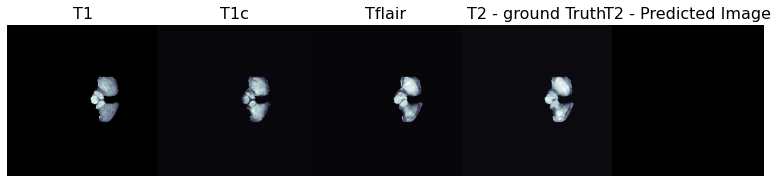

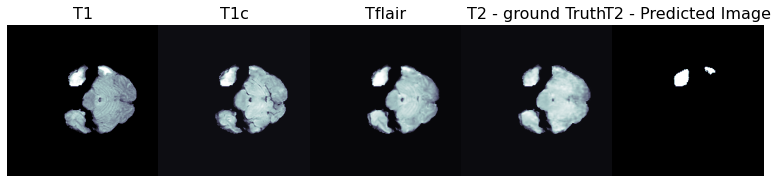

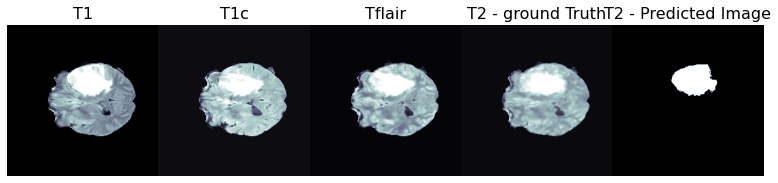

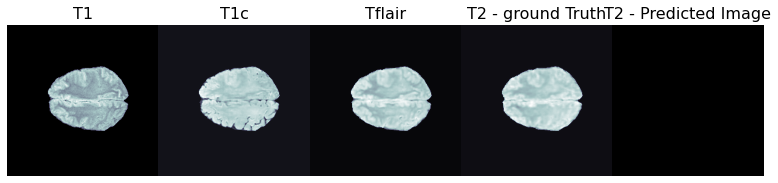

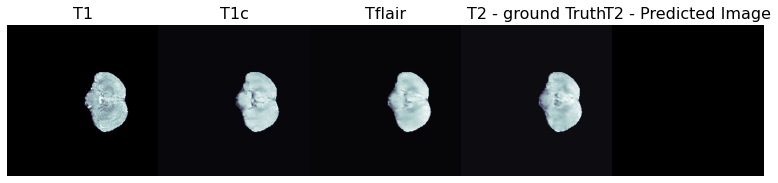

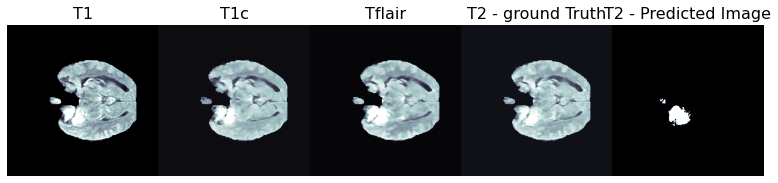

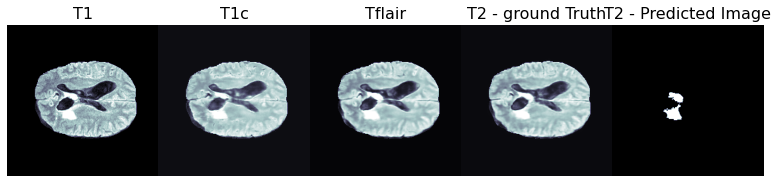

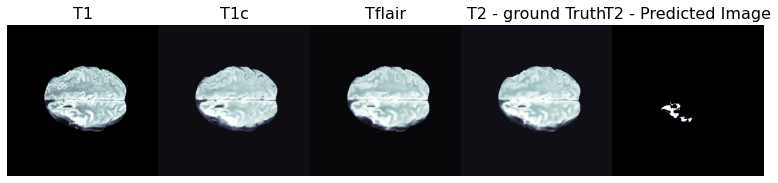

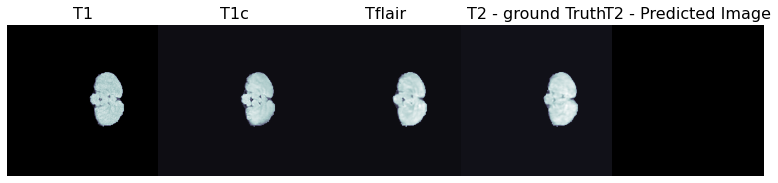

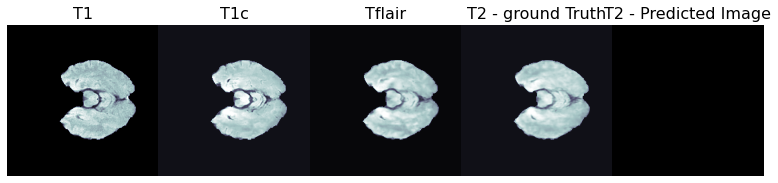

In [32]:
idx = 0
for tflair, p2p_pred, mip2p_pred, migan_pred, gt in generated_dataset.take(10):
    #print(tflair.shape)
    max_value = tf.math.reduce_max(p2p_pred)
    min_value = tf.math.reduce_min(p2p_pred)
    #print(min_value.numpy(), max_value.numpy(), (max_value-min_value).numpy())
    plot_images_new(tflair, p2p_pred, mip2p_pred, migan_pred, gt, gen_t1=True)